In [25]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import random
from skimage import morphology
import matplotlib.pyplot as plt


In [26]:
seed=42
random.seed = seed
np.random.seed(seed)
BATCH_SIZE = 1

In [30]:
data = np.load('data.npz')
X_train = data['X_train']
y_train = data['y_train']
    
data_gen_args = dict(rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
image_datagen_train = ImageDataGenerator(**data_gen_args)
mask_datagen_train = ImageDataGenerator(**data_gen_args)
image_datagen_train.fit(y_train, augment=True, seed=seed)
mask_datagen_train.fit(y_train, augment=True, seed=seed)
image_generator_train = image_datagen_train.flow(
    X_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed)
mask_generator_train = mask_datagen_train.flow(
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed)

(256, 256)


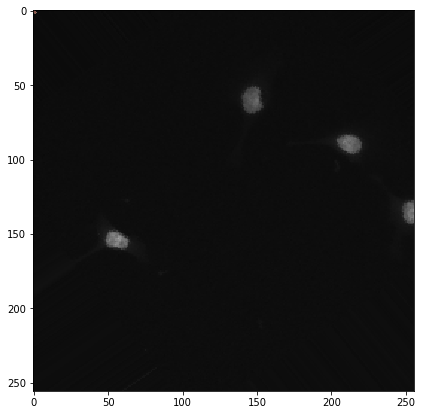

In [66]:
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())
train_generator = combine_generator(image_generator_train, mask_generator_train)

image, mask = next(train_generator)
maxValue = np.max(image)

image = np.squeeze(image, axis=0)
mask = np.squeeze(mask, axis=0)
mask = np.squeeze(mask, axis=2)
# print(image.shape)
print(mask.shape)
kernel = np.matrix([[0,0,1,0,0],
                        [0,1,1,1,0],
                        [1,1,1,1,1],
                        [0,1,1,1,0],
                        [0,0,1,0,0] ], dtype=np.bool)

contour = np.logical_xor(mask, morphology.binary_erosion(mask, kernel))
# image[:,:,1] = contour.astype(np.uint8)*255

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)
ax.imshow(contour)

ax.plot(contour,contour)

# plt.imshow(image)

plt.show()

In [48]:
plt.imshow(mask[:,:,0])
plt.show()

IndexError: too many indices for array

bool


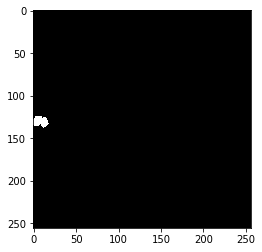

In [23]:
# image_ = np.array(image)
# image_[contour > 0] = maxValue
print(contour.dtype)
plt.imshow(np.array(contour, dtype=np.float32))
plt.show()